In [1]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import pycuda.driver as cuda

In [24]:
from livelossplot import PlotLosses
from time import sleep
import timeit

In [3]:
import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive, JitTrace_ELBO, TraceGraph_ELBO, TraceEnum_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

In [4]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [5]:
# for CI testing
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda', index=0)

In [8]:
sigma_noise = 0.1
N = 200
np.random.seed(40)

In [9]:
X1 = Uniform(torch.tensor([-1.0]), torch.tensor([-0.63])).sample(sample_shape=torch.Size([int(N/2)])).squeeze()
X2 = Uniform(torch.tensor([0.45]), torch.tensor([1.1])).sample(sample_shape=torch.Size([int(N/2)])).squeeze()
X = torch.cat((X1, X2), 0).cuda()
X.detach()

tensor([-0.7197, -0.8967, -0.8509, -0.7282, -0.9892, -0.7041, -0.8531, -0.7209,
        -0.7893, -0.8377, -0.7637, -0.8059, -0.7474, -0.8871, -0.8285, -0.8317,
        -0.7882, -0.8157, -0.6533, -0.7574, -0.8839, -0.9267, -0.8460, -0.8948,
        -0.8743, -0.8061, -0.7047, -0.7144, -0.9958, -0.7003, -0.7633, -0.6395,
        -0.6929, -0.9836, -0.9909, -0.9042, -0.6525, -0.8458, -0.7358, -0.9010,
        -0.6335, -0.8933, -0.6763, -0.8128, -0.9125, -0.7199, -0.9132, -0.7606,
        -0.8684, -0.8353, -0.9929, -0.9032, -0.7146, -0.8600, -0.6307, -0.6667,
        -0.8237, -0.9385, -0.7023, -0.7576, -0.9346, -0.6948, -0.7027, -0.6509,
        -0.9187, -0.8455, -0.8186, -0.7880, -0.9554, -0.9463, -0.7144, -0.8584,
        -0.7246, -0.8045, -0.7543, -0.7743, -0.7477, -0.7233, -0.9863, -0.7219,
        -0.9451, -0.9546, -0.8037, -0.8465, -0.7063, -0.9221, -0.9795, -0.6804,
        -0.8424, -0.7109, -0.7555, -0.9537, -0.7778, -0.7706, -0.9389, -0.9028,
        -0.7519, -0.7819, -0.8937, -0.87

In [10]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma_noise, size=N)).detach().float().cuda()
y = torch.cos(4.0*(X+0.2)) + e
y.detach()

tensor([-5.4711e-01, -9.5027e-01, -9.2713e-01, -4.2287e-01, -1.1843e+00,
        -4.7753e-01, -6.3388e-01, -4.4168e-01, -6.3674e-01, -7.2484e-01,
        -6.2646e-01, -7.2726e-01, -5.2134e-01, -8.3516e-01, -9.1112e-01,
        -8.3016e-01, -7.4848e-01, -7.2909e-01, -2.5986e-01, -7.3976e-01,
        -8.8935e-01, -9.6170e-01, -8.4538e-01, -8.0778e-01, -7.9570e-01,
        -7.1218e-01, -2.7816e-01, -4.9910e-01, -1.1371e+00, -2.8015e-01,
        -6.2794e-01, -2.1822e-01, -4.7473e-01, -1.0433e+00, -1.1335e+00,
        -9.2684e-01, -3.7955e-01, -9.0349e-01, -5.3427e-01, -9.9408e-01,
        -5.7140e-02, -8.3573e-01, -3.2039e-01, -8.1452e-01, -9.0244e-01,
        -4.6049e-01, -9.5769e-01, -5.5810e-01, -9.1028e-01, -7.5545e-01,
        -1.1184e+00, -9.7961e-01, -4.6555e-01, -9.8755e-01, -2.0653e-01,
        -4.9501e-01, -6.5714e-01, -9.1913e-01, -2.0337e-01, -6.6541e-01,
        -9.2513e-01, -4.0572e-01, -2.9669e-01, -2.4847e-01, -7.9585e-01,
        -9.5203e-01, -7.2131e-01, -7.2137e-01, -1.1

In [11]:
x_data, y_data = X.unsqueeze(1), y

In [12]:
H = 50

In [13]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(p, H)
        self.linear2 = nn.Linear(H,1)
        self.to(device)

    def forward(self, x):
        out = torch.tanh(self.linear1(x))
        out = self.linear2(out)
        return out

p = 1
softplus = nn.Softplus()
regression_model = RegressionModel(p)

In [14]:
def model(x_data, y_data):
    options = dict(dtype=x_data.dtype, device=x_data.device)
    
    weight_loc = torch.zeros(H, p, **options)
    weight_scale = 5*torch.ones(H, p, **options)
    bias_loc = torch.zeros(H, **options)
    bias_scale = 5*torch.ones(H, **options)
    
    linear1_w_prior = Normal(weight_loc, weight_scale).independent(2)
    linear1_b_prior = Normal(bias_loc, bias_scale).independent(1)
    
    weight_loc = torch.zeros(1, H, **options)
    weight_scale = 5*torch.ones(1, H, **options)
    bias_loc = torch.zeros(1, **options)
    bias_scale = 5*torch.ones(1, **options)
    
    linear2_w_prior = Normal(weight_loc, weight_scale).independent(2)
    linear2_b_prior = Normal(bias_loc, bias_scale).independent(1)
    
    priors = {'linear1.weight': linear1_w_prior, 'linear1.bias': linear1_b_prior,
              'linear2.weight': linear2_w_prior, 'linear2.bias': linear2_b_prior,}
    
    lifted_module = pyro.random_module("module", regression_model, priors)
    
    lifted_reg_model = lifted_module()
    
    with pyro.plate("map", device=x_data.device):
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        pyro.sample("obs", Normal(prediction_mean, sigma_noise), obs=y_data)
    return prediction_mean

In [15]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [16]:
pyro.clear_param_store()

In [35]:
scheduler = pyro.optim.ReduceLROnPlateau({'optimizer': torch.optim.Adam, 'optim_args': {'lr': 0.01}, 'factor': 0.5, 'patience': 2})
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(vectorize_particles=True))

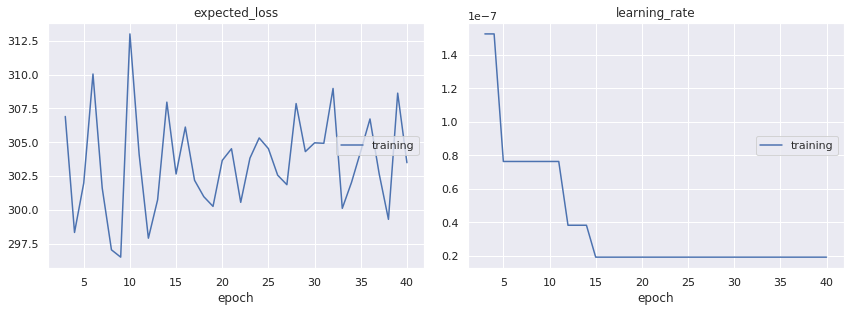

expected_loss:
training   (min:  296.494, max:  313.014, cur:  303.483)

learning_rate:
training   (min:    0.000, max:    0.000, cur:    0.000)


KeyboardInterrupt: 

In [55]:
%matplotlib inline
num_epoch = 100
num_iterations = 1000
liveloss = PlotLosses()
for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    for k in range(num_iterations):
        loss = svi.step(x_data, y_data)
        losses[k] = loss
    scheduler.step(np.mean(losses))
    L = next(iter(scheduler.optim_objs.values()))
    logs['expected_loss'] = np.mean(losses)
    logs['learning_rate'] = L.optimizer.param_groups[0]['lr']
    liveloss.update(logs)
    liveloss.draw()

In [37]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)

In [53]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).cuda()

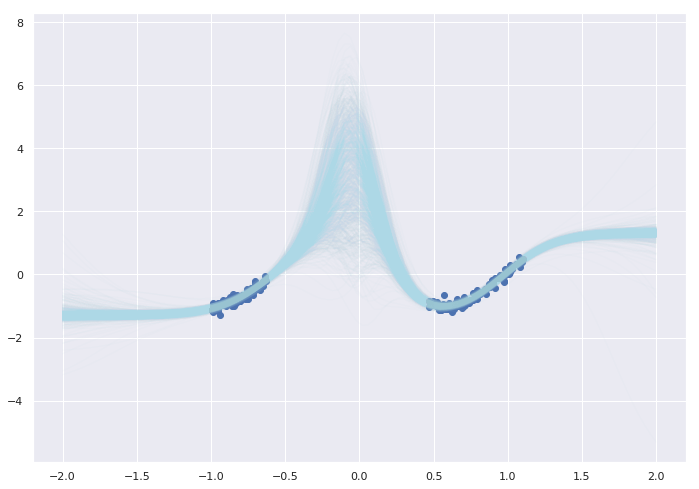

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(X.cpu(),y.cpu())
for _ in range(1000):
    guide_trace = poutine.trace(guide).get_trace(x_test, None)
    lifted_reg_model = poutine.replay(model, guide_trace)
    y_test = lifted_reg_model(x_test, None)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))